In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.linear_model import Perceptron
from sklearn.linear_model import RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report
import pickle
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False

In [2]:
print('pandas\t\t\t' + pd.__version__)
print('scikit-learn\t\t' + sklearn.__version__)
print('numpy\t\t\t' + np.__version__)
print('matplotlib\t\t' + matplotlib.__version__)
print('seaborn\t\t\t' + sns.__version__)
print('MySQL\t\t\t8.0.19')
print('Python\t\t\t3.8.3 64-bit')
print('Windows 10\t\t19041.450 64-bit')

pandas			1.0.5
scikit-learn		0.23.1
numpy			1.18.5
matplotlib		3.2.2
seaborn			0.10.1
MySQL			8.0.19
Python			3.8.3 64-bit
Windows 10		19041.450 64-bit


### 读取文件

In [3]:
companies = pd.read_csv('1.csv')
purchased = pd.read_csv('2.csv')
saled = pd.read_csv('3.csv')
standard = pd.read_csv('中小微企业标准.csv')

companies['信誉评级'].replace('A',4,inplace=True)
companies['信誉评级'].replace('B',3,inplace=True)
companies['信誉评级'].replace('C',2,inplace=True)
companies['信誉评级'].replace('D',1,inplace=True)
companies['是否违约'].replace('是',1,inplace=True)
companies['是否违约'].replace('否',0,inplace=True)

saled['年']=saled['开票日期'].apply(lambda x:str(x).split('/')[0])
saled['月']=saled['开票日期'].apply(lambda x:str(x).split('/')[1])
saled['日']=saled['开票日期'].apply(lambda x:str(x).split('/')[2])
saled['年月']=saled['开票日期'].apply(lambda x:str(x).split('/')[0]+'/'+str(x).split('/')[1])
saled['发票状态'].replace('有效发票',1,inplace=True)
saled['发票状态'].replace('作废发票',0,inplace=True)
saled['发票状态'].replace(' 作废发票',0,inplace=True)
# saled = saled[saled['发票状态']=='有效发票']

purchased['年']=purchased['开票日期'].apply(lambda x:str(x).split('/')[0])
purchased['月']=purchased['开票日期'].apply(lambda x:str(x).split('/')[1])
purchased['日']=purchased['开票日期'].apply(lambda x:str(x).split('/')[2])
purchased['年月']=purchased['开票日期'].apply(lambda x:str(x).split('/')[0]+'/'+str(x).split('/')[1])
purchased['发票状态'].replace('有效发票',1,inplace=True)
purchased['发票状态'].replace('作废发票',0,inplace=True)
# purchased = purchased[purchased['发票状态']=='有效发票']

### 年收入√

In [4]:
a = saled.groupby('企业代号')
saled_per_year = pd.DataFrame(index=saled['企业代号'].drop_duplicates(),columns=saled['年'].drop_duplicates())
for i in saled['企业代号'].drop_duplicates():
    b = a.get_group(i).groupby('年')
    c = a.get_group(i)['年'].drop_duplicates()
    for j in c:
        saled_per_year.loc[i,j] = b.get_group(j)['金额'].sum()

### 公司规模√

In [5]:
saled_per_year = saled_per_year.sort_index(axis=1)
saled_per_year['年平均'] = saled_per_year['2017']+saled_per_year['2018']+saled_per_year['2019']
saled_per_year['年平均'] = saled_per_year['年平均']/3
saled_per_year['规模'] = 0
for i in saled_per_year.index:
    if saled_per_year.at[i,'年平均'] > 60000000:
        saled_per_year.at[i,'规模'] = 4
    elif saled_per_year.at[i,'年平均'] > 2000000:
        saled_per_year.at[i,'规模'] = 3
    elif saled_per_year.at[i,'年平均'] > 200000:
        saled_per_year.at[i,'规模'] = 2
    else:
        saled_per_year.at[i,'规模'] = 1

In [6]:
a = saled_per_year['规模'].copy()
b = StandardScaler().fit_transform(saled_per_year)
b = pd.DataFrame(b,index=saled_per_year.index,columns=saled_per_year.columns)
saled_per_year = b
saled_per_year['规模'] = a.values

### 月度销售和月度累积销售√

In [7]:
a = saled.groupby('企业代号')
saled_per_month = pd.DataFrame(index=saled['企业代号'].drop_duplicates(),columns=saled['年月'].drop_duplicates())
for i in saled['企业代号'].drop_duplicates():
    b = a.get_group(i).groupby('年月')
    c = a.get_group(i)['年月'].drop_duplicates()
    for j in c:
        saled_per_month.loc[i,j] = (b.get_group(j)['金额'].sum())
saled_cumsum_per_month = saled_per_month.cumsum(axis=1)

a = saled_per_month.fillna(0)
for i in saled_per_month.index:
    plt.subplot()
    plt.plot(a.loc[i].index,a.loc[i])
    plt.show()

In [8]:
a = saled_per_month.sort_index(axis=1).fillna(0).diff(axis=1).replace(0,pd.NA)
b = StandardScaler().fit_transform(a)
b = pd.DataFrame(b,index=a.index,columns=a.columns)
saled_per_month = pd.DataFrame(b.T.mean())

In [9]:
a = saled_cumsum_per_month.sort_index(axis=1).fillna(0).diff(axis=1).replace(0,pd.NA)
b = StandardScaler().fit_transform(a)
b = pd.DataFrame(b,index=a.index,columns=a.columns)
saled_cumsum_per_month = pd.DataFrame(b.T.mean())

### 月度支出和月度累积支出√

In [10]:
a = purchased.groupby('企业代号')
purchased_per_month = pd.DataFrame(index=purchased['企业代号'].drop_duplicates(),columns=purchased['年月'].drop_duplicates())
for i in purchased['企业代号'].drop_duplicates():
    b = a.get_group(i).groupby('年月')
    c = a.get_group(i)['年月'].drop_duplicates()
    for j in c:
        purchased_per_month.loc[i,j] = (b.get_group(j)['金额'].sum())
purchased_cumsum_per_month = saled_per_month.cumsum(axis=1)

In [11]:
a = purchased_per_month.sort_index(axis=1).fillna(0).diff(axis=1).replace(0,pd.NA)
b = StandardScaler().fit_transform(a)
b = pd.DataFrame(b,index=a.index,columns=a.columns)
purchased_per_month = pd.DataFrame(b.T.mean())

In [12]:
a = purchased_cumsum_per_month.sort_index(axis=1).fillna(0).diff(axis=1).replace(0,pd.NA)
b = StandardScaler().fit_transform(a)
b = pd.DataFrame(b,index=a.index,columns=a.columns)
purchased_cumsum_per_month = pd.DataFrame(b.T.mean())

### 月度毛利润√

In [13]:
profit_per_month = pd.DataFrame(saled_per_month.sort_index(axis=1).fillna(0).values - purchased_per_month.sort_index(axis=1).fillna(0).values,index=saled_per_month.index,columns=saled_per_month.columns)
profit_cumsum_per_month = profit_per_month.cumsum(axis=1)

In [14]:
a = profit_cumsum_per_month.sort_index(axis=1).fillna(0).diff(axis=1).replace(0,pd.NA)
b = StandardScaler().fit_transform(a)
b = pd.DataFrame(b,index=a.index,columns=a.columns)
profit_cumsum_per_month = pd.DataFrame(b.T.mean())

### 月购交易次数√

In [15]:
a = purchased.groupby('企业代号')
purchased_count_per_month = pd.DataFrame(index=purchased['企业代号'].drop_duplicates(),columns=purchased['年月'].drop_duplicates())
for i in purchased['企业代号'].drop_duplicates():
    b = a.get_group(i).groupby('年月')
    c = a.get_group(i)['年月'].drop_duplicates()
    for j in c:
        purchased_count_per_month.loc[i,j] = (b.get_group(j)['销方单位代号'].count())

### 月销交易次数√

In [16]:
a = saled.groupby('企业代号')
saled_count_per_month = pd.DataFrame(index=saled['企业代号'].drop_duplicates(),columns=saled['年月'].drop_duplicates())
for i in saled['企业代号'].drop_duplicates():
    b = a.get_group(i).groupby('年月')
    c = a.get_group(i)['年月'].drop_duplicates()
    for j in c:
        saled_count_per_month.loc[i,j] = (b.get_group(j)['购方单位代号'].count())

### 月总交易次数√

In [17]:
trade_count_per_month = pd.DataFrame(purchased_count_per_month.sort_index(axis=1).fillna(0).values + saled_count_per_month.sort_index(axis=1).fillna(0).values,index=purchased_count_per_month.index,columns=purchased_count_per_month.columns)

In [18]:
a = purchased_count_per_month.sort_index(axis=1).fillna(0).diff(axis=1).replace(0,pd.NA)
b = StandardScaler().fit_transform(a)
b = pd.DataFrame(b,index=a.index,columns=a.columns)
purchased_count_per_month = pd.DataFrame(b.T.mean())

In [19]:
a = saled_count_per_month.sort_index(axis=1).fillna(0).diff(axis=1).replace(0,pd.NA)
b = StandardScaler().fit_transform(a)
b = pd.DataFrame(b,index=a.index,columns=a.columns)
saled_count_per_month = pd.DataFrame(b.T.mean())

In [20]:
a = trade_count_per_month.sort_index(axis=1).fillna(0).diff(axis=1).replace(0,pd.NA)
b = StandardScaler().fit_transform(a)
b = pd.DataFrame(b,index=a.index,columns=a.columns)
trade_count_per_month = pd.DataFrame(b.T.mean())

### 销项作废发票√

In [21]:
a = saled.groupby('企业代号')
saled_invalid_invoices = pd.DataFrame(index=purchased['企业代号'].drop_duplicates(),columns=saled['年月'].drop_duplicates())
for i in saled['企业代号'].drop_duplicates():
    b = a.get_group(i).groupby('年月')
    c = a.get_group(i)['年月'].drop_duplicates()
    for j in c:
        saled_invalid_invoices.loc[i,j] = b.get_group(j)['发票状态'].sum()

In [22]:
a = saled_invalid_invoices.sort_index(axis=1).fillna(0).diff(axis=1).replace(0,pd.NA)
b = StandardScaler().fit_transform(a)
b = pd.DataFrame(b,index=a.index,columns=a.columns)
saled_invalid_invoices = pd.DataFrame(b.T.mean())

### 购项作废发票√

In [23]:
a = purchased.groupby('企业代号')
purchased_invalid_invoices = pd.DataFrame(index=purchased['企业代号'].drop_duplicates(),columns=purchased['年月'].drop_duplicates())
for i in purchased['企业代号'].drop_duplicates():
    b = a.get_group(i).groupby('年月')
    c = a.get_group(i)['年月'].drop_duplicates()
    for j in c:
        purchased_invalid_invoices.loc[i,j] = b.get_group(j)['发票状态'].sum()

In [24]:
a = purchased_invalid_invoices.sort_index(axis=1).fillna(0).diff(axis=1).replace(0,pd.NA)
b = StandardScaler().fit_transform(a)
b = pd.DataFrame(b,index=a.index,columns=a.columns)
purchased_invalid_invoices = pd.DataFrame(b.T.mean())

### 销项负数发票√

In [25]:
a = saled.groupby('企业代号')
saled_negivative_invoices = pd.DataFrame(index=saled['企业代号'].drop_duplicates(),columns=saled['年月'].drop_duplicates())
for i in saled['企业代号'].drop_duplicates():
    b = a.get_group(i).groupby('年月')
    c = a.get_group(i)['年月'].drop_duplicates()
    for j in c:
        saled_negivative_invoices.loc[i,j] = b.get_group(j)[b.get_group(j)['价税合计']<0]['价税合计'].count()

In [26]:
a = saled_negivative_invoices.sort_index(axis=1).fillna(0).diff(axis=1).replace(0,pd.NA)
b = StandardScaler().fit_transform(a)
b = pd.DataFrame(b,index=a.index,columns=a.columns)
saled_negivative_invoices = pd.DataFrame(b.T.mean())

### 购项负数发票√

In [27]:
a = purchased.groupby('企业代号')
purchased_negivative_invoices = pd.DataFrame(index=saled['企业代号'].drop_duplicates(),columns=purchased['年月'].drop_duplicates())
for i in purchased['企业代号'].drop_duplicates():
    b = a.get_group(i).groupby('年月')
    c = a.get_group(i)['年月'].drop_duplicates()
    for j in c:
        purchased_negivative_invoices.loc[i,j] = b.get_group(j)[b.get_group(j)['价税合计']<0]['价税合计'].count()

In [28]:
a = purchased_negivative_invoices.sort_index(axis=1).fillna(0).diff(axis=1).replace(0,pd.NA)
b = StandardScaler().fit_transform(a)
b = pd.DataFrame(b,index=a.index,columns=a.columns)
purchased_negivative_invoices = pd.DataFrame(b.T.mean())

### 月税√

In [29]:
a = saled.groupby('企业代号')
tax_per_month = pd.DataFrame(index=saled['企业代号'].drop_duplicates(),columns=saled['年月'].drop_duplicates())
for i in saled['企业代号'].drop_duplicates():
    b = a.get_group(i).groupby('年月')
    c = a.get_group(i)['年月'].drop_duplicates()
    for j in c:
        tax_per_month.loc[i,j] = (b.get_group(j)['税额'].count())

In [30]:
a = tax_per_month.sort_index(axis=1).fillna(0).diff(axis=1).replace(0,pd.NA)
b = StandardScaler().fit_transform(a)
b = pd.DataFrame(b,index=a.index,columns=a.columns)
tax_per_month = pd.DataFrame(b.T.mean())

### 客户数√

In [31]:
a = saled.groupby('企业代号')
customers = pd.DataFrame(index=saled['企业代号'].drop_duplicates().drop_duplicates())
customers['客户数量'] = 0
for i in saled['企业代号'].drop_duplicates():
    customers.loc[i]['客户数量'] = a.get_group(i)['购方单位代号'].drop_duplicates().count()

In [32]:
customers = pd.DataFrame(StandardScaler().fit_transform(customers))

### 月度交易客户数量√

In [33]:
a = saled.groupby('企业代号')
customers_per_month = pd.DataFrame(index=saled['企业代号'].drop_duplicates(),columns=saled['年月'].drop_duplicates())
for i in saled['企业代号'].drop_duplicates():
    b = a.get_group(i).groupby('年月')
    c = a.get_group(i)['年月'].drop_duplicates()
    for j in c:
        customers_per_month.loc[i,j] = (b.get_group(j)['购方单位代号'].count())

In [34]:
a = customers_per_month.sort_index(axis=1).fillna(0).diff(axis=1).replace(0,pd.NA)
b = StandardScaler().fit_transform(a)
b = pd.DataFrame(b,index=a.index,columns=a.columns)
customers_per_month = pd.DataFrame(b.T.mean())

### 构建指标

In [35]:
indicators = pd.DataFrame(index=companies['企业代号'])
# indicators['年收入'] = saled_per_year['年平均'].values
indicators['规模'] = saled_per_year['规模'].values
indicators['月销售'] = saled_per_month.values
# indicators['月累积销售'] = saled_cumsum_per_month.values
indicators['月销售计数'] = saled_count_per_month.values
indicators['月支出'] = purchased_per_month.values
# indicators['月累积支出'] = purchased_cumsum_per_month.values
indicators['月支出计数'] = purchased_count_per_month.values
# indicators['月毛利润'] = profit_per_month.values
indicators['月交易计数'] = trade_count_per_month.values
indicators['销项作废发票'] = saled_invalid_invoices.values
indicators['购项作废发票'] = purchased_invalid_invoices.values
indicators['销项负数发票'] = saled_negivative_invoices.values
indicators['购项负数发票'] = purchased_negivative_invoices.values
indicators['月税'] = tax_per_month.values
indicators['客户数'] = customers.values
indicators['月交易客户数'] = customers_per_month.values
indicators['行业'] = companies['行业'].values
indicators['是否违约'] = companies['是否违约'].values
indicators['信誉评级'] = companies['信誉评级'].values
indicators.fillna(0,inplace=True)
n_features = indicators.shape[1] - 3
# indicators

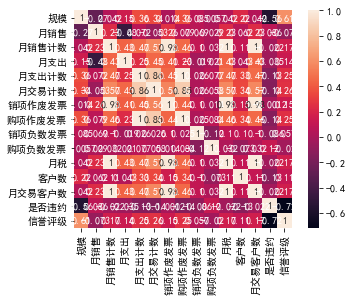

In [36]:
idct = indicators.copy()
del idct['行业']
sns.heatmap(idct.corr(),square=True, annot=True)

### 是否违约PCA定阶

In [37]:
default_optimal_n_features = pd.DataFrame(PCA(0.99).fit(idct.iloc[:,:n_features],idct.iloc[:,n_features]).explained_variance_ratio_).shape[0]

### 信誉评级PCA定阶

In [38]:
credit_rating_optimal_n_features = pd.DataFrame(PCA(0.99).fit(idct.iloc[:,:n_features+1],idct.iloc[:,n_features+1]).explained_variance_ratio_).shape[0]

### 违约状况PCA

In [39]:
pre_n_features = n_features
n_features = default_optimal_n_features
a = PCA(n_features).fit(idct.iloc[:,:pre_n_features])
idct = pd.DataFrame(np.dot(idct.iloc[:,:pre_n_features],a.components_.T),index=companies.index)
idct['是否违约'] = indicators['是否违约'].values

### 是否违约

In [40]:
X_train,X_test,y_train,y_test = train_test_split(idct.iloc[:,:n_features],idct.iloc[:,n_features],test_size=0.3)
perptn = SVC().fit(X_train,y_train)
y_pred = perptn.predict(X_test)
print(classification_report(y_pred,y_test))

precision    recall  f1-score   support

           0       0.86      0.86      0.86        29
           1       0.50      0.50      0.50         8

    accuracy                           0.78        37
   macro avg       0.68      0.68      0.68        37
weighted avg       0.78      0.78      0.78        37



In [41]:
# X_train,X_test,y_train,y_test = train_test_split(idct.iloc[:,:n_features],idct.iloc[:,n_features],test_size=0.3)
perptn = Perceptron().fit(X_train,y_train)
y_pred = perptn.predict(X_test)
print(classification_report(y_pred,y_test))

precision    recall  f1-score   support

           0       0.90      0.87      0.88        30
           1       0.50      0.57      0.53         7

    accuracy                           0.81        37
   macro avg       0.70      0.72      0.71        37
weighted avg       0.82      0.81      0.82        37



In [42]:
# X_train,X_test,y_train,y_test = train_test_split(idct.iloc[:,:n_features],idct.iloc[:,n_features],test_size=0.3)
tree = LogisticRegression().fit(X_train,y_train)
y_pred = tree.predict(X_test)
print(classification_report(y_pred,y_test))

precision    recall  f1-score   support

           0       0.90      0.87      0.88        30
           1       0.50      0.57      0.53         7

    accuracy                           0.81        37
   macro avg       0.70      0.72      0.71        37
weighted avg       0.82      0.81      0.82        37



In [43]:
# X_train,X_test,y_train,y_test = train_test_split(idct.iloc[:,:n_features],idct.iloc[:,n_features],test_size=0.3)
tree = DecisionTreeClassifier().fit(X_train,y_train)
y_pred = tree.predict(X_test)
print(classification_report(y_pred,y_test))

precision    recall  f1-score   support

           0       0.90      0.84      0.87        31
           1       0.38      0.50      0.43         6

    accuracy                           0.78        37
   macro avg       0.64      0.67      0.65        37
weighted avg       0.81      0.78      0.80        37



In [44]:
# X_train,X_test,y_train,y_test = train_test_split(idct.iloc[:,:n_features],idct.iloc[:,n_features],test_size=0.3)
tree = DecisionTreeClassifier().fit(X_train,y_train)
y_pred = tree.predict(X_test)
print(classification_report(y_pred,y_test))

precision    recall  f1-score   support

           0       0.90      0.84      0.87        31
           1       0.38      0.50      0.43         6

    accuracy                           0.78        37
   macro avg       0.64      0.67      0.65        37
weighted avg       0.81      0.78      0.80        37



In [45]:
# X_train,X_test,y_train,y_test = train_test_split(idct.iloc[:,:n_features],idct.iloc[:,n_features],test_size=0.3)
bag = BaggingClassifier().fit(X_train,y_train)
y_pred = bag.predict(X_test)
print(classification_report(y_pred,y_test))

precision    recall  f1-score   support

           0       0.97      0.85      0.90        33
           1       0.38      0.75      0.50         4

    accuracy                           0.84        37
   macro avg       0.67      0.80      0.70        37
weighted avg       0.90      0.84      0.86        37



In [46]:
# X_train,X_test,y_train,y_test = train_test_split(idct.iloc[:,:n_features],idct.iloc[:,n_features],test_size=0.3)
forest = RandomForestClassifier().fit(X_train,y_train)
y_pred = forest.predict(X_test)
print(classification_report(y_pred,y_test))

precision    recall  f1-score   support

           0       0.90      0.84      0.87        31
           1       0.38      0.50      0.43         6

    accuracy                           0.78        37
   macro avg       0.64      0.67      0.65        37
weighted avg       0.81      0.78      0.80        37



In [47]:
# X_train,X_test,y_train,y_test = train_test_split(idct.iloc[:,:n_features],idct.iloc[:,n_features],test_size=0.3)
ada = AdaBoostClassifier(DecisionTreeClassifier(),n_estimators=100).fit(X_train,y_train)
y_pred = ada.predict(X_test)
print(classification_report(y_pred,y_test))

precision    recall  f1-score   support

           0       0.90      0.84      0.87        31
           1       0.38      0.50      0.43         6

    accuracy                           0.78        37
   macro avg       0.64      0.67      0.65        37
weighted avg       0.81      0.78      0.80        37



In [48]:
# X_train,X_test,y_train,y_test = train_test_split(idct.iloc[:,:n_features],idct.iloc[:,n_features],test_size=0.3)
gbc = GradientBoostingClassifier().fit(X_train,y_train)
y_pred = gbc.predict(X_test)
print(classification_report(y_pred,y_test))

precision    recall  f1-score   support

           0       0.90      0.84      0.87        31
           1       0.38      0.50      0.43         6

    accuracy                           0.78        37
   macro avg       0.64      0.67      0.65        37
weighted avg       0.81      0.78      0.80        37



In [49]:
with open('是否违约.pickle', 'wb') as f:
    pickle.dump(tree, f)

### 信誉评级PCA

In [50]:
idct = indicators.copy()
del idct['行业']
pre_n_features = pre_n_features + 1
n_features = credit_rating_optimal_n_features
a = PCA(n_features).fit(idct.iloc[:,:pre_n_features])
idct = pd.DataFrame(np.dot(idct.iloc[:,:pre_n_features],a.components_.T),index=companies.index)
idct['信誉评级'] = indicators['信誉评级'].values

### 信誉评级

In [51]:
X_train,X_test,y_train,y_test = train_test_split(idct.iloc[:,:n_features],idct.iloc[:,n_features],test_size=0.3)
perptn = SVC().fit(X_train,y_train)
y_pred = perptn.predict(X_test)
print(classification_report(y_pred,y_test))

precision    recall  f1-score   support

           1       0.80      1.00      0.89         4
           2       0.90      0.35      0.50        26
           3       0.00      0.00      0.00         0
           4       0.71      0.71      0.71         7

    accuracy                           0.49        37
   macro avg       0.60      0.52      0.53        37
weighted avg       0.85      0.49      0.58        37



In [52]:
# X_train,X_test,y_train,y_test = train_test_split(idct.iloc[:,:n_features],idct.iloc[:,n_features],test_size=0.3)
perptn = Perceptron().fit(X_train,y_train)
y_pred = perptn.predict(X_test)
print(classification_report(y_pred,y_test))

precision    recall  f1-score   support

           1       0.80      1.00      0.89         4
           2       0.20      0.40      0.27         5
           3       0.00      0.00      0.00         0
           4       1.00      0.25      0.40        28

    accuracy                           0.35        37
   macro avg       0.50      0.41      0.39        37
weighted avg       0.87      0.35      0.43        37



In [53]:
# X_train,X_test,y_train,y_test = train_test_split(idct.iloc[:,:n_features],idct.iloc[:,n_features],test_size=0.3)
tree = LogisticRegression().fit(X_train,y_train)
y_pred = tree.predict(X_test)
print(classification_report(y_pred,y_test))

precision    recall  f1-score   support

           1       0.80      1.00      0.89         4
           2       0.10      0.14      0.12         7
           3       0.60      0.56      0.58        16
           4       0.71      0.50      0.59        10

    accuracy                           0.51        37
   macro avg       0.55      0.55      0.54        37
weighted avg       0.56      0.51      0.53        37



In [54]:
# X_train,X_test,y_train,y_test = train_test_split(idct.iloc[:,:n_features],idct.iloc[:,n_features],test_size=0.3)
tree = DecisionTreeClassifier().fit(X_train,y_train)
y_pred = tree.predict(X_test)
print(classification_report(y_pred,y_test))

precision    recall  f1-score   support

           1       0.80      0.80      0.80         5
           2       0.30      0.19      0.23        16
           3       0.33      0.56      0.42         9
           4       0.29      0.29      0.29         7

    accuracy                           0.38        37
   macro avg       0.43      0.46      0.43        37
weighted avg       0.37      0.38      0.36        37



In [55]:
# X_train,X_test,y_train,y_test = train_test_split(idct.iloc[:,:n_features],idct.iloc[:,n_features],test_size=0.3)
bag = BaggingClassifier().fit(X_train,y_train)
y_pred = bag.predict(X_test)
print(classification_report(y_pred,y_test))

precision    recall  f1-score   support

           1       0.80      0.80      0.80         5
           2       0.50      0.31      0.38        16
           3       0.33      0.45      0.38        11
           4       0.29      0.40      0.33         5

    accuracy                           0.43        37
   macro avg       0.48      0.49      0.48        37
weighted avg       0.46      0.43      0.43        37



In [56]:
# X_train,X_test,y_train,y_test = train_test_split(idct.iloc[:,:n_features],idct.iloc[:,n_features],test_size=0.3)
forest = RandomForestClassifier().fit(X_train,y_train)
y_pred = forest.predict(X_test)
print(classification_report(y_pred,y_test))

precision    recall  f1-score   support

           1       0.80      1.00      0.89         4
           2       0.40      0.31      0.35        13
           3       0.33      0.50      0.40        10
           4       0.86      0.60      0.71        10

    accuracy                           0.51        37
   macro avg       0.60      0.60      0.59        37
weighted avg       0.55      0.51      0.52        37



In [57]:
# X_train,X_test,y_train,y_test = train_test_split(idct.iloc[:,:n_features],idct.iloc[:,n_features],test_size=0.3)
ada = AdaBoostClassifier(DecisionTreeClassifier(),n_estimators=100).fit(X_train,y_train)
y_pred = ada.predict(X_test)
print(classification_report(y_pred,y_test))

precision    recall  f1-score   support

           1       0.80      0.80      0.80         5
           2       0.20      0.13      0.16        15
           3       0.27      0.36      0.31        11
           4       0.29      0.33      0.31         6

    accuracy                           0.32        37
   macro avg       0.39      0.41      0.39        37
weighted avg       0.31      0.32      0.31        37



In [58]:
# X_train,X_test,y_train,y_test = train_test_split(idct.iloc[:,:n_features],idct.iloc[:,n_features],test_size=0.3)
gbc = GradientBoostingClassifier().fit(X_train,y_train)
y_pred = gbc.predict(X_test)
print(classification_report(y_pred,y_test))

precision    recall  f1-score   support

           1       0.80      1.00      0.89         4
           2       0.40      0.40      0.40        10
           3       0.53      0.53      0.53        15
           4       0.57      0.50      0.53         8

    accuracy                           0.54        37
   macro avg       0.58      0.61      0.59        37
weighted avg       0.53      0.54      0.54        37



In [59]:
with open('信誉评级.pickle', 'wb') as f:
    pickle.dump(gbc, f)

In [60]:
indicators.to_csv('信誉和违约预测模型.csv',encoding='gbk')